### Potrzebne importy

In [1]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd 
import matplotlib.pylab as plt

### Stałe:
- SAMPLE_DATA_PATH - ścieżka do przykładowych danych
- SAMPLE_NODE_PATH - ścieżka do danych z zaznaczonymi punktami

W folderze `SAMPLE_DATA_PATH` znajduje się tylko jeden plik. Tak samo w `node.csv` są dane dotyczącego tylko jednego skanu.

In [2]:
SAMPLE_DATA_PATH = "data/sample"
SAMPLE_NODE_PATH = "data/sample/node.csv"

**Wczytywanie zdjęć:**

In [3]:
ct_scans = []
for path in filter(lambda x: x.endswith(".mhd"), os.listdir(SAMPLE_DATA_PATH)):
    image = sitk.ReadImage(os.path.join(SAMPLE_DATA_PATH, path))
    ct_scans.append(sitk.GetArrayFromImage(image))

**Wczytanie pliku z labelami**:

In [4]:
nodes_df = pd.read_csv(SAMPLE_NODE_PATH)
nodes_df

,seriesuid,coordX,coordY,coordZ,class
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,14.120000,-1.780000,-73.660000,0
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,10.610000,14.330000,-42.700000,0
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,-93.090000,53.570000,-125.030000,0
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,36.540000,68.290000,-72.960000,0
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,-106.400000,11.530000,-120.100000,0
...,...,...,...,...,...
436,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,-7.687654,79.264055,-101.194719,0
437,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,-89.927081,37.071374,-121.054191,0
438,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,39.227882,-0.922502,-107.754927,0
439,1.3.6.1.4.1.14519.5.2.1.6279.6001.109002525524...,-102.207343,31.200716,-39.677511,0


**Wyświetlenie scanu:**

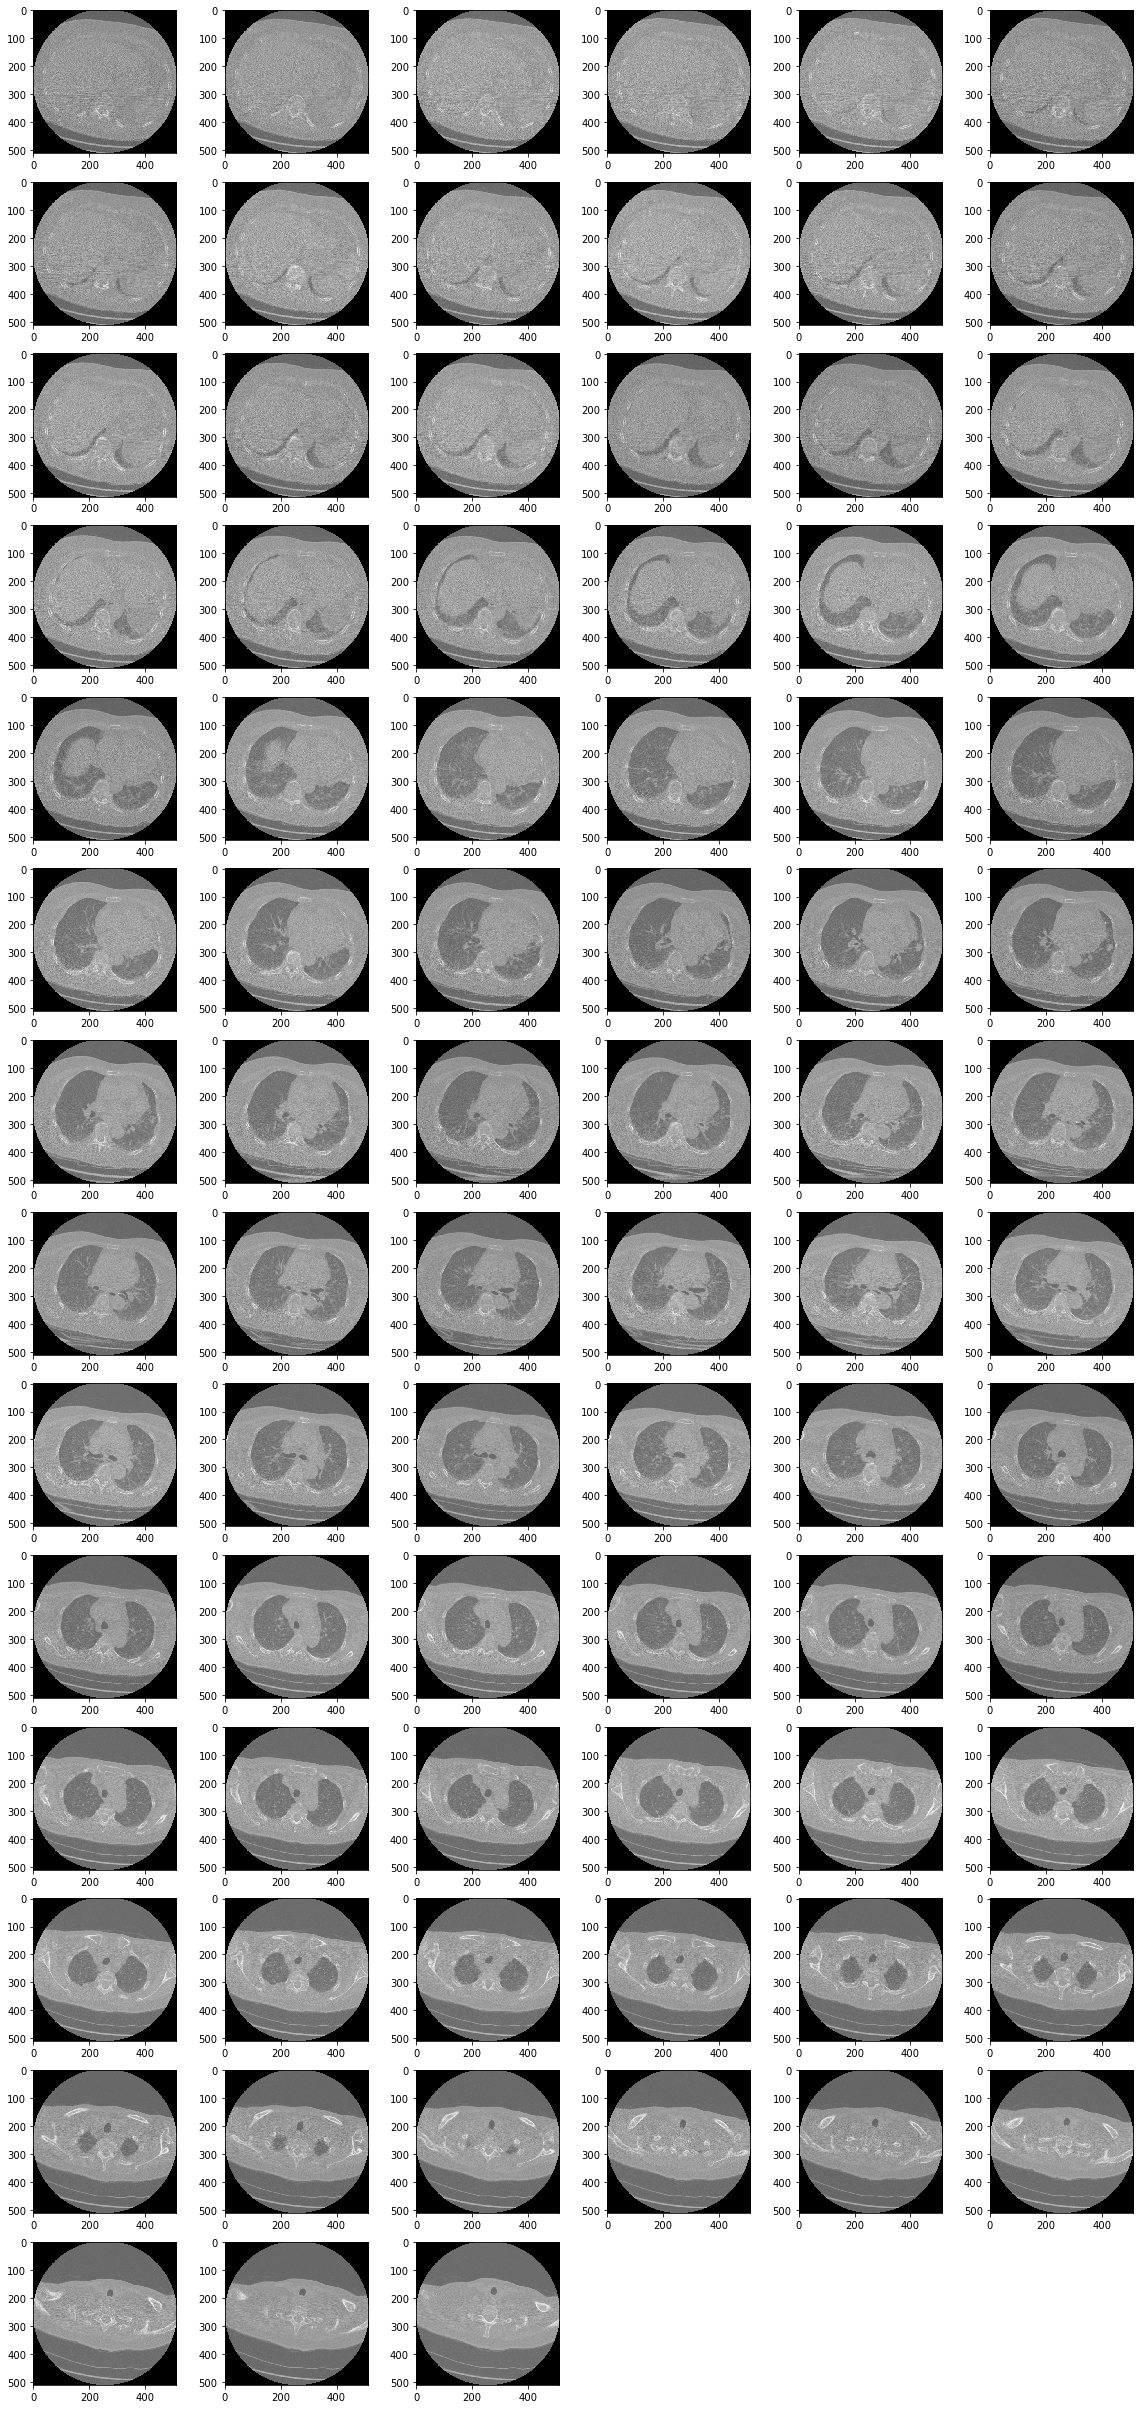

In [5]:
def draw_slices(slices):
    fig = plt.figure(figsize=(20, 50))
    for i, testSlice in enumerate(slices[::2]):
        subplot = fig.add_subplot((len(slices) / 2) / 5, 5 + 1, i + 1)
        subplot.imshow(testSlice, cmap='gray')
    plt.show()
    
    
draw_slices(ct_scans[0])

**Wczytuje scan z `SAMPLE_DATA_PATH/<filename>`**

Funkcja zwraca 3 parametry:
- tablicę zdjęć 
- origin - koordynaty środka
- spacing - ile paciorków mają pixele w rzeczywistości

In [6]:
def load_scan(filename):
    scan_data = sitk.ReadImage(os.path.join(SAMPLE_DATA_PATH, filename))
    origin = np.array(scan_data.GetOrigin())
    spacing = np.array(scan_data.GetSpacing())

    return sitk.GetArrayFromImage(scan_data), origin, spacing

**Funkcje ułatwiające obsługę współrzędnych**
- `get_coords_from_node_row` - pobiera współrzędne z wiersza dataframa
- `create_coords_converter` - tworzy konwerter współrzędnych dla wybranych parametrów

In [7]:
def convert_to_voxel_coords(origin, spacing, coords):
    voxel_coords = [np.absolute(coords[i]-origin[i])/spacing[i] for i in range(len(coords))]
    return tuple(voxel_coords)

def create_coords_converter(origin, spacing):
    return lambda coords: convert_to_voxel_coords(origin, spacing, coords);

def get_coords_from_node_row(row):
    return row[["coordX", "coordY", "coordZ"]]

**Wycinanie obrazka z skanu**

In [8]:
def crop_subimage(slices, converter, coords, width = 50):
    x, y, z = converter(coords)
    return slices[int(z), int(y - width / 2):int(y + width / 2), int(x - width / 2):int(x + width / 2)]

**Normalizacja**
- konwersja z hounds units do grayscale units
- zapisanie jako uint8

In [9]:
def normalize_image(image):
    """From SITK - converting hounds units to grayscale units"""
    maxHU = 400.0
    minHU = -1000.0
    
    image = (image - minHU) / (maxHU - minHU)
    image[image > 1] = 1.0
    image[image < 0] = 0.0
    
    return (image * 255).astype(np.uint8);

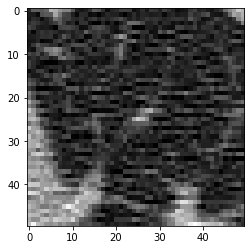

In [16]:
def crop_test():
    test_file_name = list(filter(lambda x: x.endswith(".mhd"), os.listdir(SAMPLE_DATA_PATH)))[0];

    scan, origin,spacing  = load_scan(test_file_name)
    converter = create_coords_converter(origin, spacing)
    first_node_row = nodes_df[nodes_df["seriesuid"] == test_file_name[:-4]].iloc[0]
    coords = get_coords_from_node_row(first_node_row)
    
    subimage = crop_subimage(scan, converter, coords)
    subimage = normalize_image(subimage)
    plt.imshow(subimage, cmap='gray')
    
crop_test()

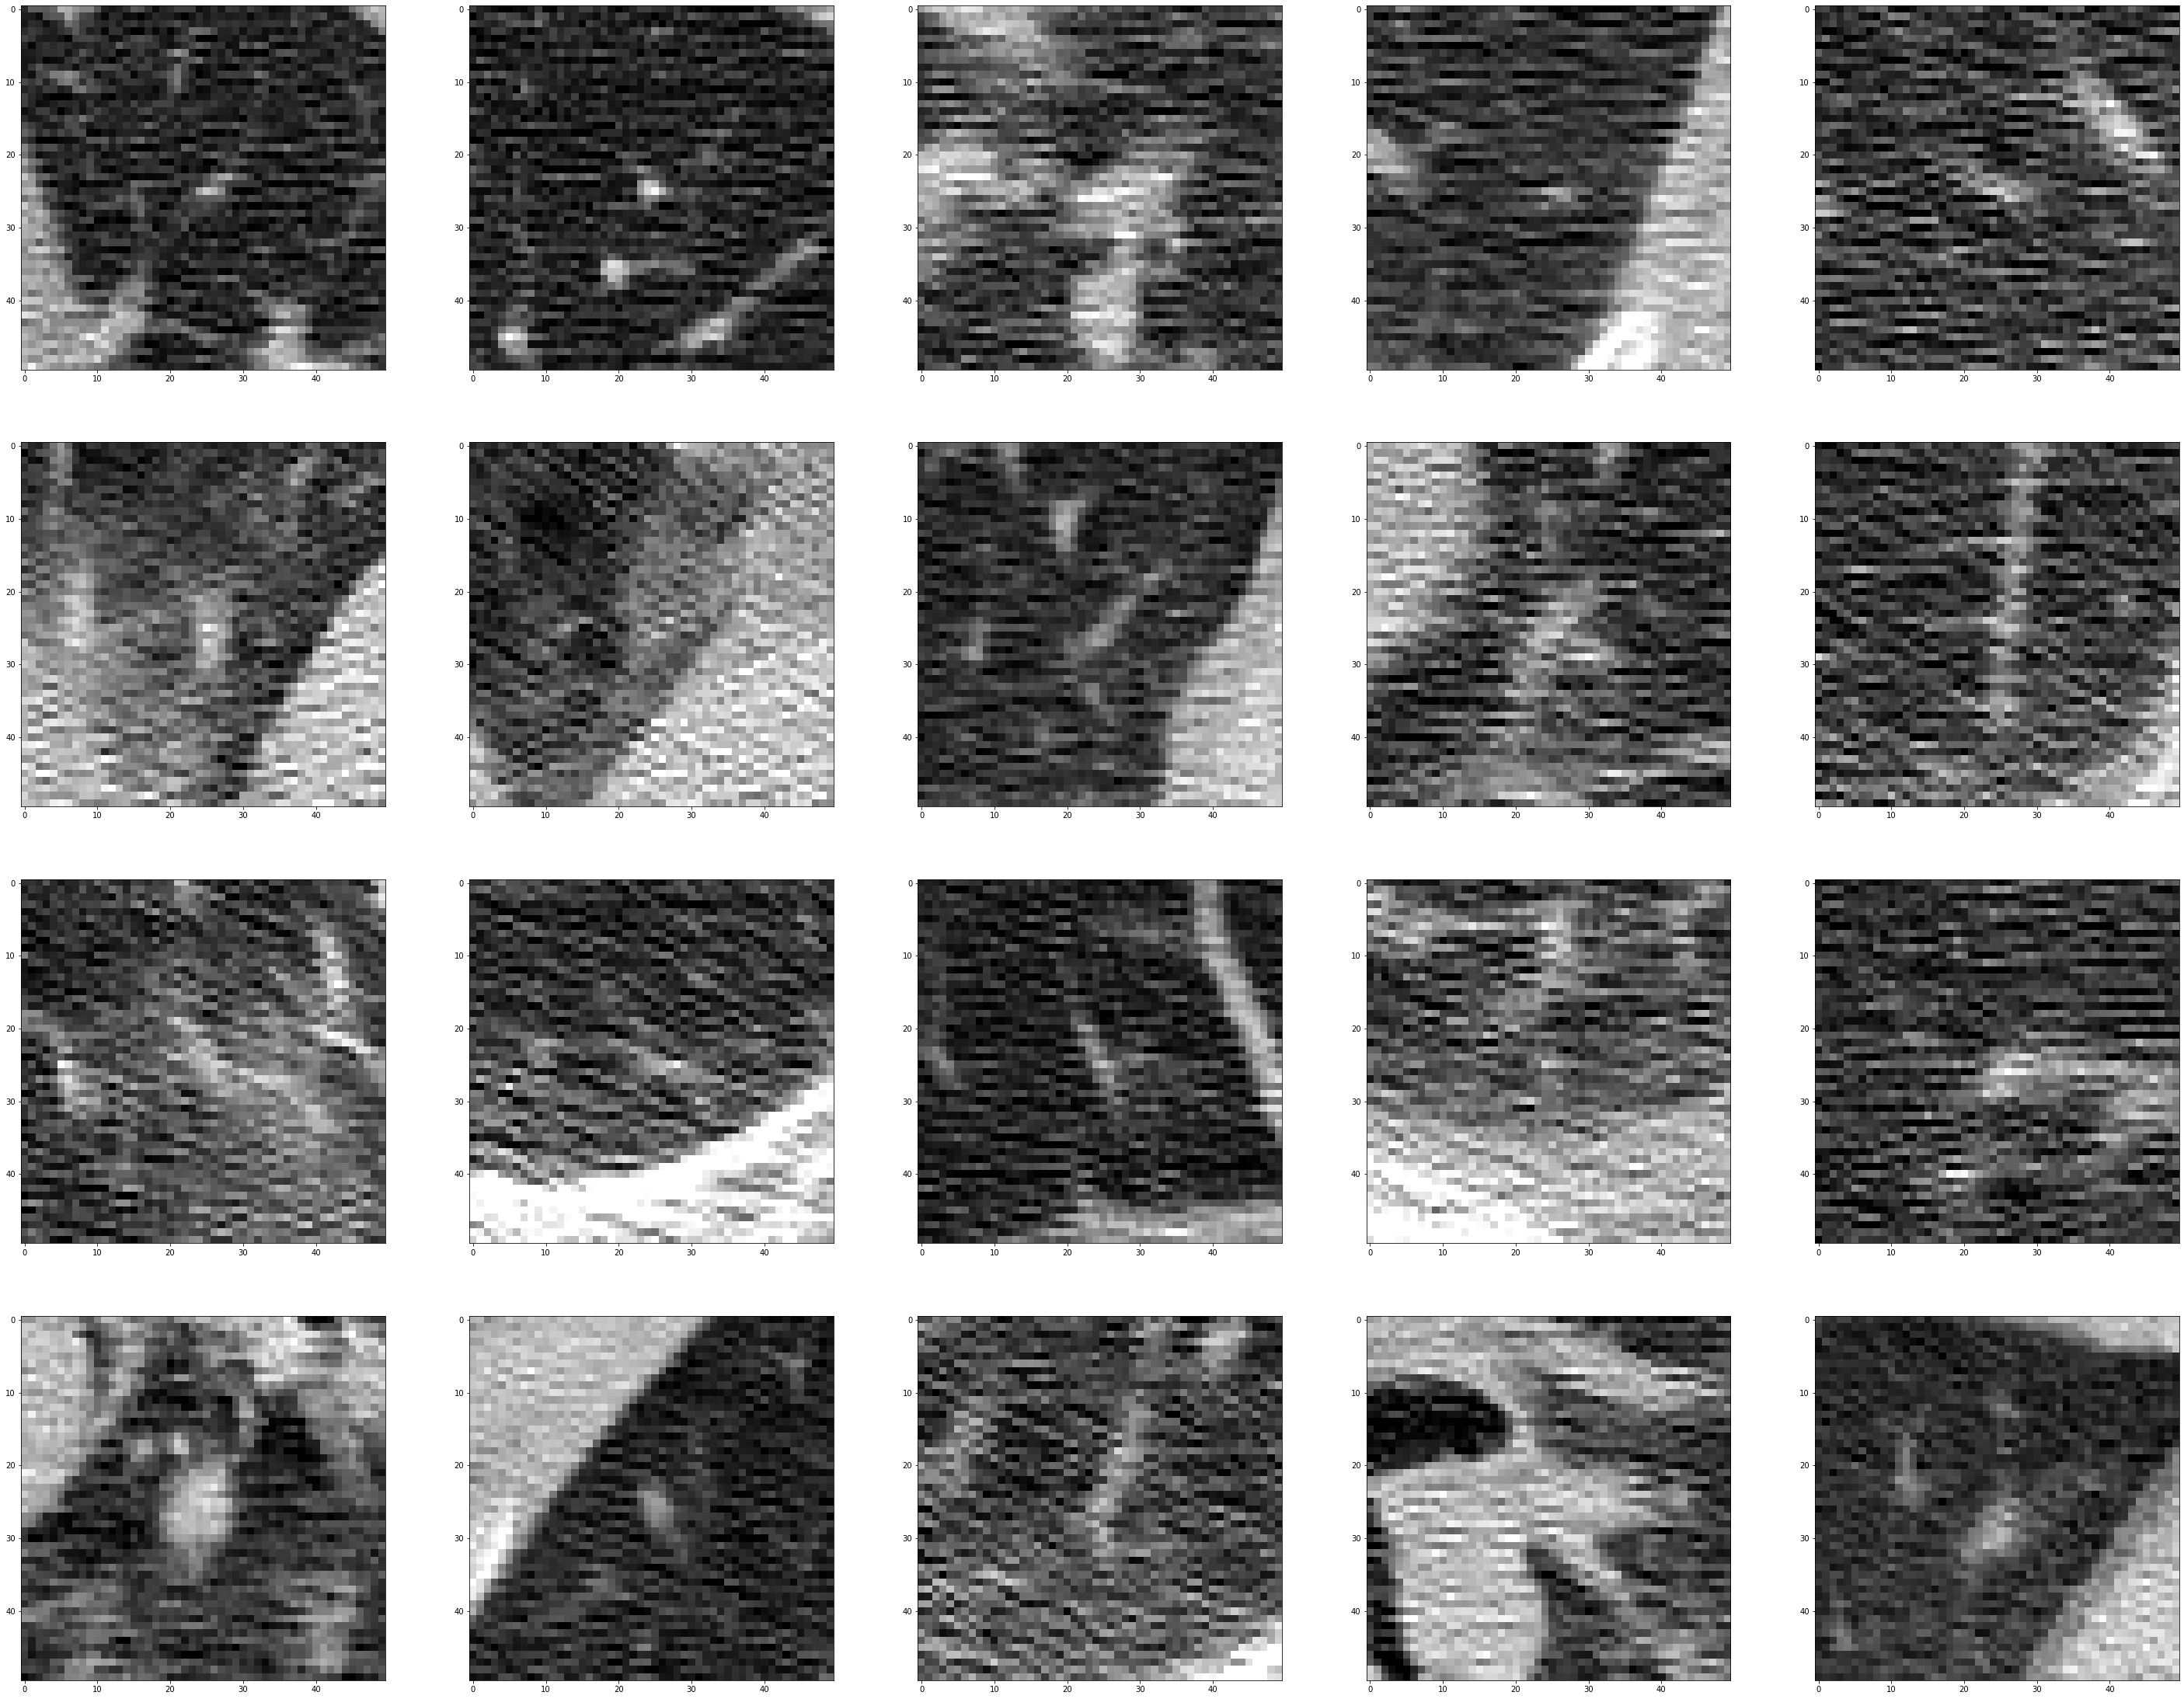

In [11]:
def extract_features():
    test_file_name = list(filter(lambda x: x.endswith(".mhd"), os.listdir(SAMPLE_DATA_PATH)))[0];
    
    scan, origin, spacing = load_scan(test_file_name)
    converter = create_coords_converter(origin, spacing)
    
    suspicious_places = nodes_df[nodes_df["seriesuid"] == test_file_name[:-4]][:20]
    size = len(suspicious_places)
    fig = plt.figure(figsize=(50, 50))
    
    for i, row in suspicious_places.iterrows():
        coords = get_coords_from_node_row(row)

        subimage = crop_subimage(scan, converter, coords)
        subimage = normalize_image(subimage)
        
        subplot = fig.add_subplot(size / 5 + 1, 5, i + 1)
        subplot.imshow(subimage, cmap='gray')
    
    plt.show()

extract_features()